Optimal order_quantity for price 26 and cost 20 is 26.24
Reward type: Terminal, theta_step: 50, T: 24 - Average reward over 100 iterations is: 90.15
Order quantity for iteration 74
[21.56100244269893, 21.985330589799354, 22.40965873689978, 22.833986884000204, 21.41955972699879, 21.843288540558113, 22.26641971122102, 22.689550881883925, 23.11268205254683, 23.535813223209736, 23.958944393872642, 22.548507158329624, 22.971042369597228, 21.564572608697087, 20.160078226674614, 20.581426541281356, 21.00218390453521, 21.422941267789067, 21.843698631042923, 22.264455994296778, 20.861931450117254, 19.46137122602762, 19.88153929325451, 20.30111971283493]


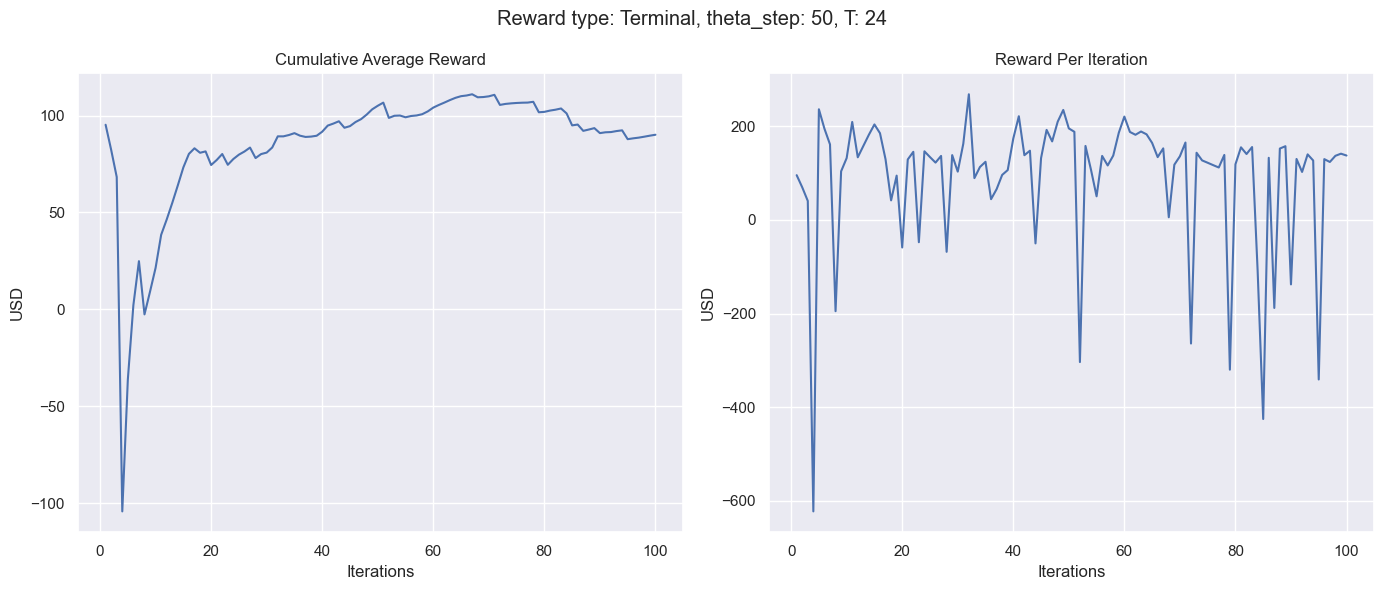

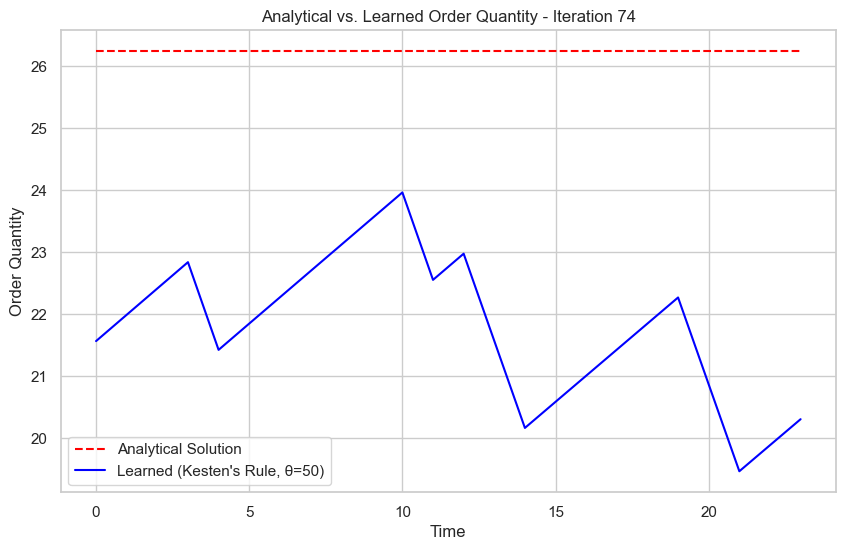

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dataclasses import dataclass

@dataclass
class State:
    order_quantity: float
    counter: int

@dataclass
class Decision:
    step_size: float

class AdaptiveMarketPlanningModel:
    """Base class for the Adaptive Market Planning model."""

    def __init__(self, s_0, T, reward_type, price=1.0, cost=1.0, seed=20180613):
        """
        Initialize the Adaptive Market Planning model.

        :param s_0: Initial state dictionary
        :param T: Number of time steps
        :param reward_type: Type of reward ('Cumulative' or 'Terminal')
        :param price: Price of the product (default: 1.0)
        :param cost: Cost of the product (default: 1.0)
        :param seed: Random seed for reproducibility (default: 20180613)
        """
        self.prng = np.random.RandomState(seed)
        self.state = State(*s_0.values())
        self.T = T
        self.reward_type = reward_type
        self.obj = 0.0
        self.past_derivative = 0.0
        self.cost = cost
        self.price = price
        self.t = 0
        self.learning_list = []

    def exog_info_fn(self, decision):
        """
        Generate exogenous information (demand) based on the decision.

        :param decision: Decision object
        :return: Dictionary containing the demand information
        """
        return {'demand': self.prng.exponential(100)}

    def transition_fn(self, decision, exog_info):
        """
        Update the state based on the decision and exogenous information.

        :param decision: Decision object
        :param exog_info: Dictionary containing the exogenous information
        """
        self.learning_list.append(self.state.order_quantity)
        derivative = self.price - self.cost if self.state.order_quantity < exog_info['demand'] else -self.cost
        new_order_quantity = max(0, self.state.order_quantity + decision.step_size * derivative)
        new_counter = self.state.counter + (self.past_derivative * derivative < 0)
        self.past_derivative = derivative
        self.state = State(new_order_quantity, new_counter)

    def objective_fn(self, decision, exog_info):
        """
        Calculate the objective function value based on the decision and exogenous information.

        :param decision: Decision object
        :param exog_info: Dictionary containing the exogenous information
        :return: Objective function value
        """
        return self.price * min(self.state.order_quantity, exog_info['demand']) - self.cost * self.state.order_quantity

    def step(self, decision):
        """
        Perform a single step of the Adaptive Market Planning model.

        :param decision: Decision object
        """
        self.t += 1
        exog_info = self.exog_info_fn(decision)
        onestep_contribution = self.objective_fn(decision, exog_info)
        self.obj += onestep_contribution if self.reward_type == 'Cumulative' else (onestep_contribution if self.t == self.T else 0)
        self.transition_fn(decision, exog_info)

class AdaptiveMarketPlanningPolicy:
    """Base class for the Adaptive Market Planning policy."""

    def __init__(self, model, theta_step):
        """
        Initialize the Adaptive Market Planning policy.

        :param model: Adaptive Market Planning model object
        :param theta_step: Step size parameter for the policy
        """
        self.model = model
        self.theta_step = theta_step

    def kesten_rule(self):
        """
        Apply Kesten's rule to determine the step size.

        :return: Decision object with the calculated step size
        """
        return Decision(self.theta_step / (self.theta_step + self.model.state.counter - 1))

    def run_policy(self):
        """
        Run the Adaptive Market Planning policy for the specified number of time steps.

        :return: Tuple containing the final objective value and the learning list
        """
        for _ in range(self.model.T):
            self.model.step(self.kesten_rule())
        return self.model.obj, self.model.learning_list.copy()

# Set up the model parameters
cost, price, theta_step, T, reward_type = 20, 26, 50, 24, "Terminal"
trial_size = 100

# Initialize the model and policy
init_state = {'order_quantity': 0, 'counter': 0}
model = AdaptiveMarketPlanningModel(init_state, T, reward_type, price, cost)
policy = AdaptiveMarketPlanningPolicy(model, theta_step)

# Run multiple iterations of the policy
rewards_per_iteration = np.zeros(trial_size)
learning_list_per_iteration = []
for ite in range(trial_size):
    model.t = 0
    model.obj = 0.0
    model.learning_list = []
    reward, learning_list = policy.run_policy()
    rewards_per_iteration[ite] = reward
    learning_list_per_iteration.append(learning_list)

# Calculate cumulative average rewards
nElem = np.arange(1, trial_size + 1)
rewards_per_iteration_cum_avg = rewards_per_iteration.cumsum() / nElem
if reward_type == "Cumulative":
    rewards_per_iteration_cum_avg /= T
    rewards_per_iteration /= T

# Calculate the optimal order quantity
optimal_order_quantity = -np.log(cost / price) * 100

# Print the results
print(f"Optimal order_quantity for price {price} and cost {cost} is {optimal_order_quantity:.2f}")
print(f"Reward type: {reward_type}, theta_step: {theta_step}, T: {T} - Average reward over {trial_size} iterations is: {rewards_per_iteration_cum_avg[-1]:.2f}")

# Select a random iteration for plotting
ite = np.random.randint(trial_size)
order_quantity = learning_list_per_iteration[ite]
print(f"Order quantity for iteration {ite}")
print(order_quantity)

# Set up Seaborn style
sns.set(style="darkgrid")

# Plot the reward trends
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(f"Reward type: {reward_type}, theta_step: {theta_step}, T: {T}")

sns.lineplot(x=nElem, y=rewards_per_iteration_cum_avg, ax=axs[0])
axs[0].set_title('Cumulative Average Reward')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('USD')

sns.lineplot(x=nElem, y=rewards_per_iteration, ax=axs[1])
axs[1].set_title('Reward Per Iteration')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('USD')

plt.tight_layout()
plt.show()

# Plot the analytical vs. learned order quantity
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
plt.title(f"Analytical vs. Learned Order Quantity - Iteration {ite}")
time = np.arange(len(order_quantity))
sns.lineplot(x=time, y=[optimal_order_quantity] * len(time), color='red', linestyle='--', label="Analytical Solution")
sns.lineplot(x=time, y=order_quantity, color='blue', label=f"Learned (Kesten's Rule, θ={theta_step})")
plt.xlabel("Time")
plt.ylabel("Order Quantity")
plt.legend()
plt.show()
